In [250]:
pip install pandas scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [251]:
import pandas as pd
import csv
import sklearn
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2, f_regression, f_classif
import seaborn as sns
import numpy as np
import datetime

#### The Dataset for this analysis is the 2019 UK Road Traffic Dataset
#### Objectives: 
###### 1. What hours of the day and days of the week record the highest accident
###### 2. For Motorbikes, are there significant hours of the day of days of the week , on which accidents occur
###### 3. For Pedestrian are there significant hours of the day of days of the week , on which accidents occur
###### 4. What impact, if any, does daylight savings have on road traffic accidents in the week after it starts and stops?
###### 5. Are there particular conditions (weather, geographic location, situations) that generate more road traffic accidents?
###### 6. How does driver related variables affect the outcome (e.g., age of the driver, and the purpose of the journey)?


In [252]:
####Read all three dataset in
accidents_df=pd.read_csv('./dataset/Road Safety Data - Accidents 2019.csv', low_memory=False)
vehicles_df =pd.read_csv('./dataset/Road Safety Data- Vehicles 2019.csv', low_memory=False)
casualties_df=pd.read_csv('./dataset/Road Safety Data - Casualties 2019.csv', low_memory=False)

## 1. What hours of the day and days of the week record the highest accident

In [253]:
accidents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117536 entries, 0 to 117535
Data columns (total 32 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   Accident_Index                               117536 non-null  object 
 1   Location_Easting_OSGR                        117508 non-null  float64
 2   Location_Northing_OSGR                       117508 non-null  float64
 3   Longitude                                    117508 non-null  float64
 4   Latitude                                     117508 non-null  float64
 5   Police_Force                                 117536 non-null  int64  
 6   Accident_Severity                            117536 non-null  int64  
 7   Number_of_Vehicles                           117536 non-null  int64  
 8   Number_of_Casualties                         117536 non-null  int64  
 9   Date                                         117536 non-nul

In [254]:
###Check for colums with missing values
accidents_df.isnull().sum()

Accident_Index                                    0
Location_Easting_OSGR                            28
Location_Northing_OSGR                           28
Longitude                                        28
Latitude                                         28
Police_Force                                      0
Accident_Severity                                 0
Number_of_Vehicles                                0
Number_of_Casualties                              0
Date                                              0
Day_of_Week                                       0
Time                                             63
Local_Authority_(District)                        0
Local_Authority_(Highway)                         0
1st_Road_Class                                    0
1st_Road_Number                                   0
Road_Type                                         0
Speed_limit                                       0
Junction_Detail                                   0
Junction_Con

###### Function definitions


In [255]:
###Clean missing time by replacing missing value with 
accidents_df['Time'] = accidents_df['Time'].fillna(method='ffill')
#Convert time to datetime 
#Create a function to convert date related columns to datetime as they both currently appear as an object
def timeDate(col):
    accidents_df[col] = pd.to_datetime(accidents_df[col])
#Create a function that adds a new column with hourly time conversion
def hourlyTime(df):
    df['hour'] = df.Time.dt.hour
    df['minute'] = df.Time.dt.minute
    df['hourly_time'] = df.hour + (df.minute/60)
#     df['day'] = df.Date.dt.day
#Create a function to define either morning, off-peak, afternoon rush ,end of work or late night
def timePeriod(hour):
    if hour in range (6,10):
        return 'Morning Rush Hour(6,10)'
    elif hour in range(10-15):
        return 'Off Peak Period (10-15)'
    elif hour in range (15,19):
        return 'Afternoon Rush Hour(15-19)'
    elif hour in range (19,23):
        return 'End of Work(19-23)'
    else:
        return 'Late Night (23-6)'
    
#Create function to convert variables with object datatypes to string
def objToString(df,col):
    df[col] = df[col].apply(str)
    
    
#Applying functions to dataframe
#covert time to datetime
timeDate('Time')
timeDate('Date')
#Get time at hourly intervals
hourlyTime(accidents_df)
#hour classification based on rush
accidents_df['rushTime'] = accidents_df['hour'].apply(timePeriod)

# Convert day_of_week from int to str representing each day
accidents_df['Week_Day'] = accidents_df['Day_of_Week'].map({1: 'Sunday', 2:'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday'})


/tmp/ipykernel_78/2173358288.py:6: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  accidents_df[col] = pd.to_datetime(accidents_df[col])


###### Accident chart by hour of the day

<Figure size 1000x1200 with 0 Axes>

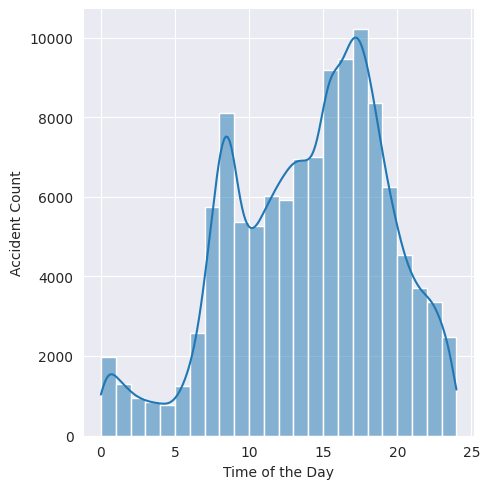

In [256]:
# Chart that shows accident frequency accross hours of the day
%matplotlib inline
sns.set_style('darkgrid')
plt.figure(figsize= (10,12))
sns.displot(data=accidents_df, x=accidents_df['hourly_time'], kde=True, bins =24)
plt.xlabel('Time of the Day')
plt.ylabel('Accident Count')
plt.show()

###### Accident by specific hour of the day

Text(0, 0.5, 'Accident Count')

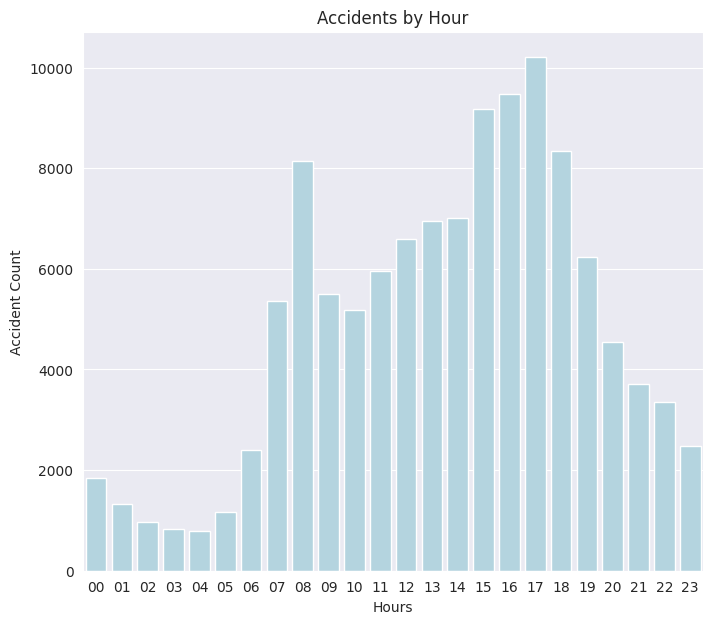

In [257]:
#Accident by specific hour of the day
hours = pd.DataFrame(accidents_df["Time"].astype("datetime64[ns]"))
hours = pd.DataFrame(hours.Time.dt.strftime('%H').sort_values(),columns=["Time"])
plt.figure(figsize=(8,7))
sns.countplot(data=hours,x="Time", color="lightblue")
plt.title("Accidents by Hour")
plt.xlabel("Hours")
plt.ylabel("Accident Count")

##### Accident by day of the week

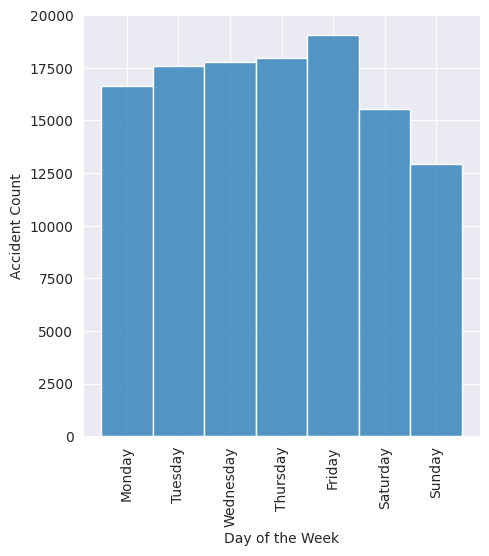

6    19056
5    17973
4    17775
3    17598
2    16643
7    15556
1    12935
Name: Day_of_Week, dtype: int64

In [258]:
###Accident distribution by day of the week
%matplotlib inline
sns.set_style('darkgrid')
sns.displot(data=accidents_df,x=accidents_df["Week_Day"], bins = 7)
plt.xlabel("Day of the Week")
plt.ylabel("Accident Count")
plt.xticks(rotation=90)
plt.show()
days = accidents_df['Day_of_Week'].value_counts()
days

## 2. Motorbike Accidents
### What hours of the day and days of the week are accident more likely to occur involving motorbikes?

In [259]:
# Vehicle type that classifies as motorbike are 2,3,4,5,23,97
# Dataframe of vehicles that identify as motorbike
bikes = vehicles_df.loc[vehicles_df['Vehicle_Type'].isin([2,3,4,5,23,97])]
# Merge motorbikes_df with accidents_df

motorbikes_df = accidents_df.merge(bikes, on=['Accident_Index'], how='inner')

###### Motorbike accidents by hour of the day

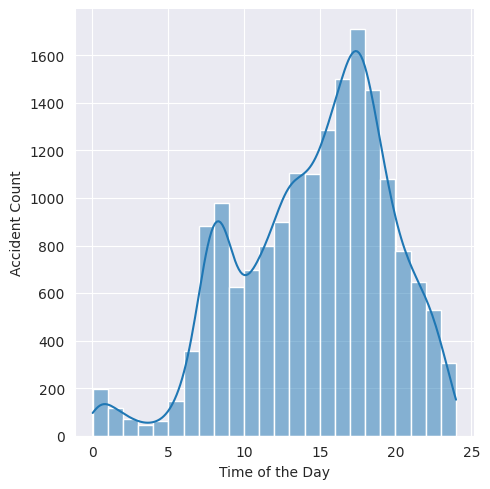

In [260]:
%matplotlib inline
sns.set_style('darkgrid')
sns.displot(data=motorbikes_df,x="hourly_time",kde=True, bins = 24)
plt.xlabel("Time of the Day")
plt.ylabel("Accident Count")
plt.show()

###### Motorbik accidents by specific hours of the day

Text(0, 0.5, 'Accident Count')

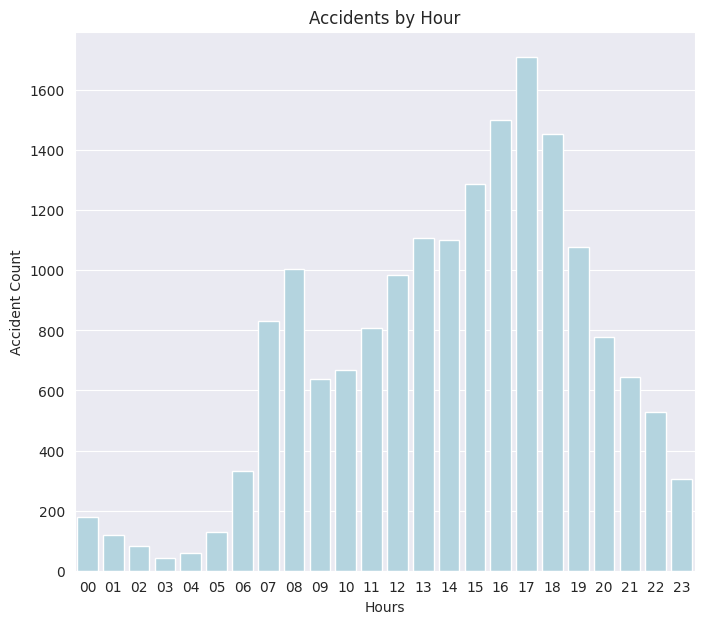

In [261]:
#Motorbike accident by specific hour of the day
# First convert "Time" to datatime to allow for time operations to be performed 
hours = pd.DataFrame(motorbikes_df["Time"].astype("datetime64[ns]"))
#Extract hourly times
hours = pd.DataFrame(hours.Time.dt.strftime('%H').sort_values(),columns=["Time"])
plt.figure(figsize=(8,7))
sns.countplot(data=hours,x="Time", color="lightblue")
plt.title("Accidents by Hour")
plt.xlabel("Hours")  
plt.ylabel("Accident Count")

In [262]:
###### Motorbike accidents by days of the week

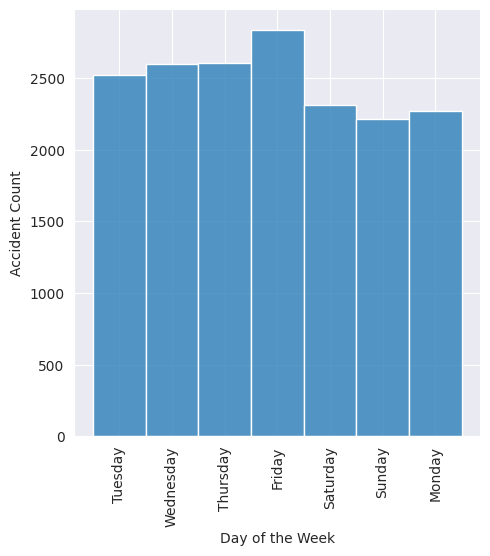

In [263]:
#Accident for motorbikes for days of the week
%matplotlib inline
sns.set_style('darkgrid')
sns.displot(data=motorbikes_df,x="Week_Day", bins = 7)
plt.xlabel("Day of the Week")
plt.ylabel("Accident Count")
plt.xticks(rotation=90)
plt.show()

## 3. For Pedestrian are there significant hours of the day of days of the week , on which accidents occur?

In [264]:
# Read in casualties dataframe that shows pedestrian data
# Key for pedestrian is 0
casualties_df.head()

,Accident_Index,Vehicle_Reference,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,Casualty_IMD_Decile
0,2019010128300,1,1,1,1,58,9,3,0,0,0,0,0,9,1,2
1,2019010128300,1,2,2,2,-1,-1,3,0,0,1,0,0,9,1,5
2,2019010128300,1,3,2,2,-1,-1,3,0,0,2,0,0,9,1,5
3,2019010152270,1,1,1,2,24,5,3,0,0,0,0,0,9,1,3
4,2019010155191,2,1,2,2,21,5,3,0,0,0,0,0,1,1,1


In [265]:
# Extract pedestrian df from casualties dataframe to show pedestrian data
pedestrians = casualties_df[(casualties_df['Casualty_Type'] == 0)]
pedestrians

,Accident_Index,Vehicle_Reference,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,Casualty_IMD_Decile
5,2019010155192,1,1,3,1,68,10,2,5,4,0,0,0,0,1,4
11,2019010155196,1,1,3,1,40,7,3,1,3,0,0,0,0,1,4
19,2019010155209,1,1,3,1,23,5,3,1,1,0,0,0,0,1,8
20,2019010155210,1,1,3,1,24,5,1,5,1,0,0,0,0,1,10
21,2019010155216,1,1,3,1,38,7,3,5,3,0,0,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153108,2019983114119,1,1,3,1,64,9,2,5,1,0,0,0,0,1,4
153113,2019983115619,1,1,3,1,0,1,3,9,8,0,0,0,0,-1,-1
153131,2019984104219,1,1,3,2,75,10,2,6,9,0,0,0,0,2,4
153132,2019984104419,1,1,3,1,16,4,3,6,9,0,0,0,0,2,6


In [266]:
#Merge pedetrian dataframe with accident dataframe
pedestrians_df = accidents_df.merge(pedestrians, on=['Accident_Index'], how='inner')
#Map week days variable code to match various week days 
pedestrians_df['Week_Day'] = pedestrians_df['Day_of_Week'].map({1: 'Sunday', 2:'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday'})
pedestrians_df

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,Casualty_IMD_Decile
0,2019010155192,525531.0,184605.0,-0.191044,51.546387,1,2,1,1,2019-01-01,...,10,2,5,4,0,0,0,0,1,4
1,2019010155196,532424.0,164886.0,-0.099071,51.367605,1,3,1,1,2019-01-01,...,7,3,1,3,0,0,0,0,1,4
2,2019010155209,543649.0,186237.0,0.070738,51.556734,1,3,1,1,2019-01-01,...,5,3,1,1,0,0,0,0,1,8
3,2019010155210,537356.0,183448.0,-0.021065,51.533238,1,1,1,1,2019-01-01,...,5,1,5,1,0,0,0,0,1,10
4,2019010155216,532724.0,185103.0,-0.087182,51.549218,1,3,1,1,2019-01-01,...,7,3,5,3,0,0,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21765,2019983114119,297464.0,576134.0,-3.607229,55.069052,98,2,1,1,2019-01-06,...,9,2,5,1,0,0,0,0,1,4
21766,2019983115619,296071.0,577414.0,-3.629501,55.080260,98,3,1,1,2019-06-19,...,1,3,9,8,0,0,0,0,-1,-1
21767,2019984104219,313523.0,582066.0,-3.357641,55.125401,98,2,1,1,2019-05-04,...,10,2,6,9,0,0,0,0,2,4
21768,2019984104419,331608.0,566975.0,-3.070480,54.992647,98,3,1,1,2019-09-04,...,4,3,6,9,0,0,0,0,2,6


###### Pedestrian accidents by hours of the day

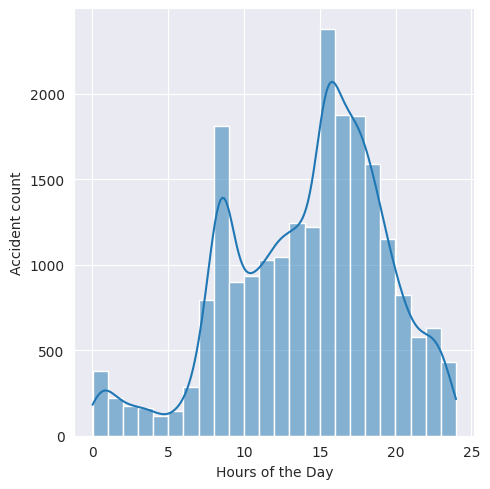

In [267]:
#pedestrian
%matplotlib inline
sns.set_style('darkgrid')
sns.displot(data=pedestrians_df, x= 'hourly_time', kde = True, bins =24)
plt.xlabel("Hours of the Day")
plt.ylabel("Accident count")
plt.show()

###### Pedestrian accidents by specific hour of the day

Text(0, 0.5, 'Accident Count')

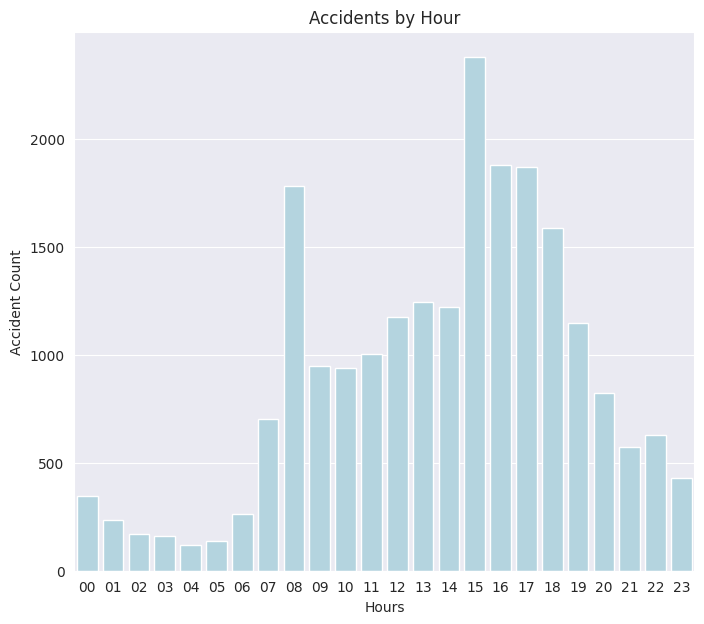

In [268]:
#Motorbike accident by specific hour of the day
# First convert "Time" to datatime to allow for time operations to be performed 
hours = pd.DataFrame(pedestrians_df["Time"].astype("datetime64[ns]"))
#Extract hourly times
hours = pd.DataFrame(hours.Time.dt.strftime('%H').sort_values(),columns=["Time"])
plt.figure(figsize=(8,7))
sns.countplot(data=hours,x="Time", color="lightblue")
plt.title("Accidents by Hour")
plt.xlabel("Hours")
plt.ylabel("Accident Count")

###### Pedetrian accidents by days of the week

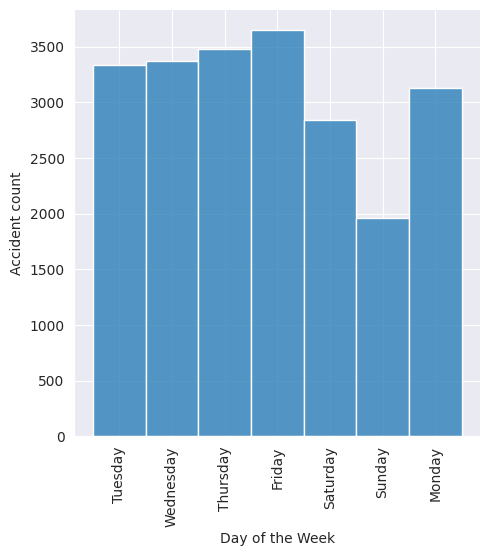

In [269]:
%matplotlib inline
sns.set_style('darkgrid')
sns.displot(data=pedestrians_df, x= 'Week_Day', bins= 7)
plt.xlabel("Day of the Week")
plt.ylabel("Accident count")
plt.xticks(rotation=90)
plt.show()

## 4. What impact, if any, does daylight savings have on road traffic accidents in the week after it starts and stops?


In [270]:
accidents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117536 entries, 0 to 117535
Data columns (total 37 columns):
 #   Column                                       Non-Null Count   Dtype         
---  ------                                       --------------   -----         
 0   Accident_Index                               117536 non-null  object        
 1   Location_Easting_OSGR                        117508 non-null  float64       
 2   Location_Northing_OSGR                       117508 non-null  float64       
 3   Longitude                                    117508 non-null  float64       
 4   Latitude                                     117508 non-null  float64       
 5   Police_Force                                 117536 non-null  int64         
 6   Accident_Severity                            117536 non-null  int64         
 7   Number_of_Vehicles                           117536 non-null  int64         
 8   Number_of_Casualties                         117536 non-null  in

##### Daylight saving time 2019 in United Kingdom began at 01:00 on Sunday, 31 March and ended at 02:00 on Sunday, 27 October All times are in United Kingdom Time.
###### The typical implementation of Daylight saving time  is to set clocks forward by one hour in the spring ("spring forward"), and to set clocks back by one hour in autumn ("fall back") to return to standard time. As a result, there is one 23-hour day in late winter or early spring and one 25-hour day in autumn

In [271]:
#Get when daylight start and add a week to it 
#Get dayligh saving stop period and add a weeks to it to observe changes to accident figures
# Daylight savings started 03/31/2019
# Daylight saving stopped 10/27/2019
#i.e a week after daylight savings started would be 
dayLightStartWeek = datetime.datetime(2019,3,31) + datetime.timedelta(weeks=1)
dayLightStopWeek = datetime.datetime(2019,10,27) + datetime.timedelta(weeks=1)
# date_interval = pd.date_range(start="2019-03-31", end=dayLightStartWeek )
# Get a dataframe showing dates a week daylight savings started and a week after it ended 
start_df = accidents_df.loc[accidents_df['Date'].isin(pd.date_range(start="2019-03-31", end=dayLightStartWeek))]
stop_df = accidents_df.loc[accidents_df['Date'].isin(pd.date_range(start="2019-10-27", end=dayLightStopWeek))]
len(stop_df) - len(start_df)
# Percentage Increase a week after daylight ended
percent_increase = ((len(stop_df)-len(start_df))/len(start_df))*100
text = 'The increse in accident frequency a week after daylight saving time ended is {:.0f}%'
print(text.format(percent_increase))

The increse in accident frequency a week after daylight saving time ended is 2%


## 5. Are there particular conditions (weather, geographic location, situations) that generate more road traffic accidents?


##### Weather conditions

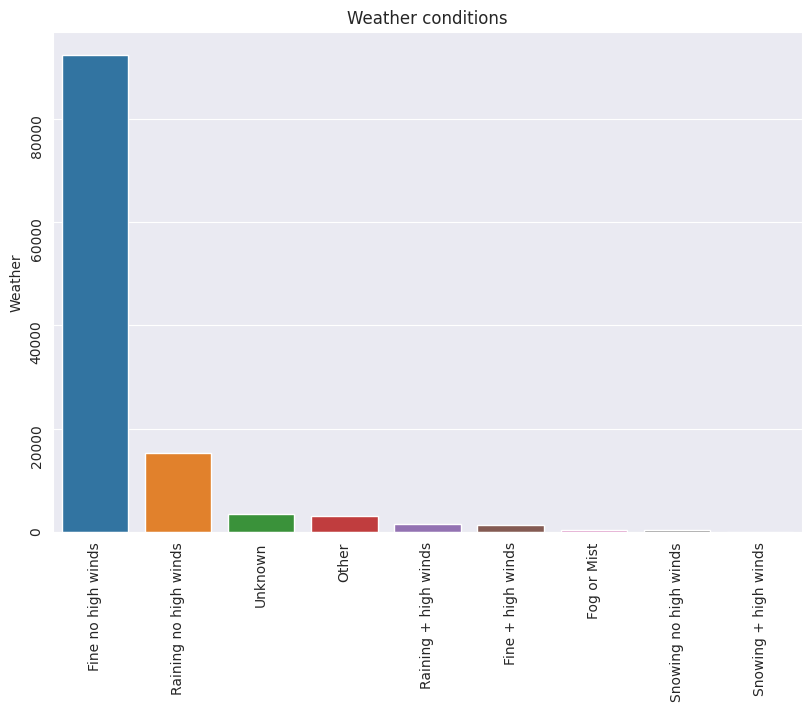

Fine no high winds       92316
Raining no high winds    15294
Unknown                   3436
Other                     3043
Raining + high winds      1430
Fine + high winds         1230
Fog or Mist                394
Snowing no high winds      353
Snowing + high winds        40
Name: Weather, dtype: int64

In [272]:
accidents_df['Weather_Conditions'].unique()

accidents_df['Weather'] = accidents_df['Weather_Conditions'].map({1: 'Fine no high winds', 2: 'Raining no high winds', 3: 'Snowing no high winds', 4: 'Fine + high winds', 5: 'Raining + high winds', 6: 'Snowing + high winds', 7: 'Fog or Mist', 8: 'Other', 9: 'Unknown'})
fig, axs = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(8,7))
weather = accidents_df["Weather"].value_counts()
sns.barplot(ax=axs, x = weather.index, y = weather)
axs.set_title("Weather conditions")
axs.tick_params(labelrotation=90)
plt.show()
weather

###### Road Type

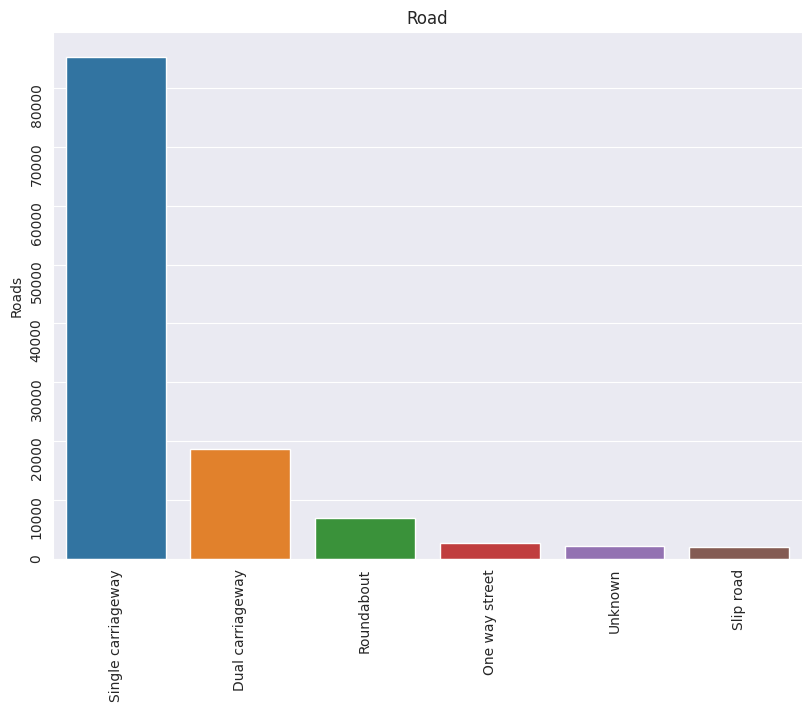

Single carriageway    85320
Dual carriageway      18590
Roundabout             6880
One way street         2664
Unknown                2143
Slip road              1939
Name: Roads, dtype: int64

In [273]:
accidents_df['Roads'] = accidents_df['Road_Type'].map({1: 'Roundabout', 2: 'One way street', 3: 'Dual carriageway', 6: 'Single carriageway', 7: 'Slip road', 9: 'Unknown'})
roads = accidents_df['Roads'].value_counts()
# Road type
fig, axs = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(8,7))
sns.barplot(ax=axs, x = roads.index, y = roads)
axs.set_title("Road")
axs.tick_params(labelrotation=90)
plt.show()
roads

###### Speed Limit

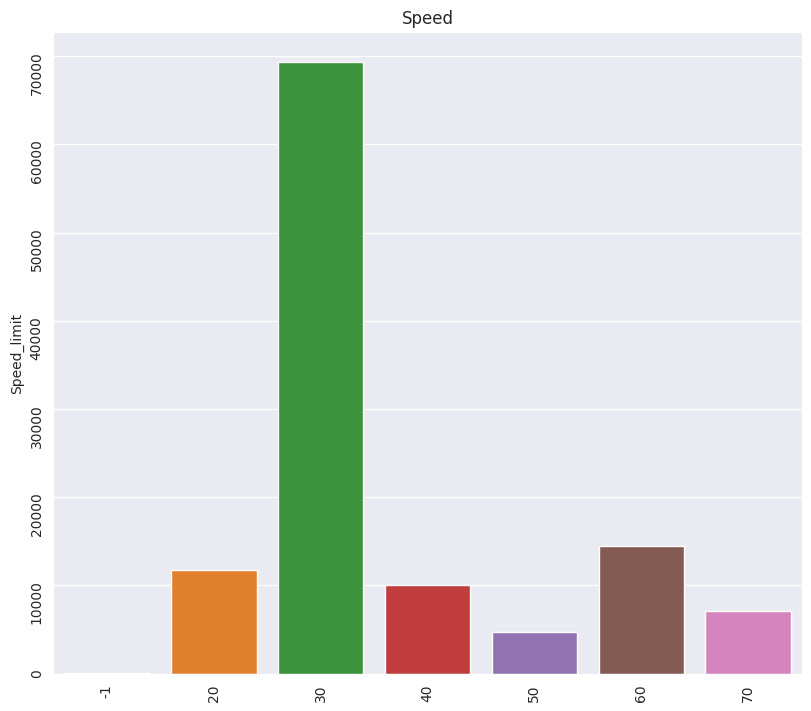

 30    69305
 60    14514
 20    11747
 40    10021
 70     7153
 50     4716
-1        80
Name: Speed_limit, dtype: int64

In [274]:
fig, axs = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(8,7))
speed = accidents_df['Speed_limit'].value_counts()
sns.barplot(ax=axs, x = speed.index, y = speed)
axs.set_title("Speed")
axs.tick_params(labelrotation=90)
plt.show()
speed

##### Road Surface

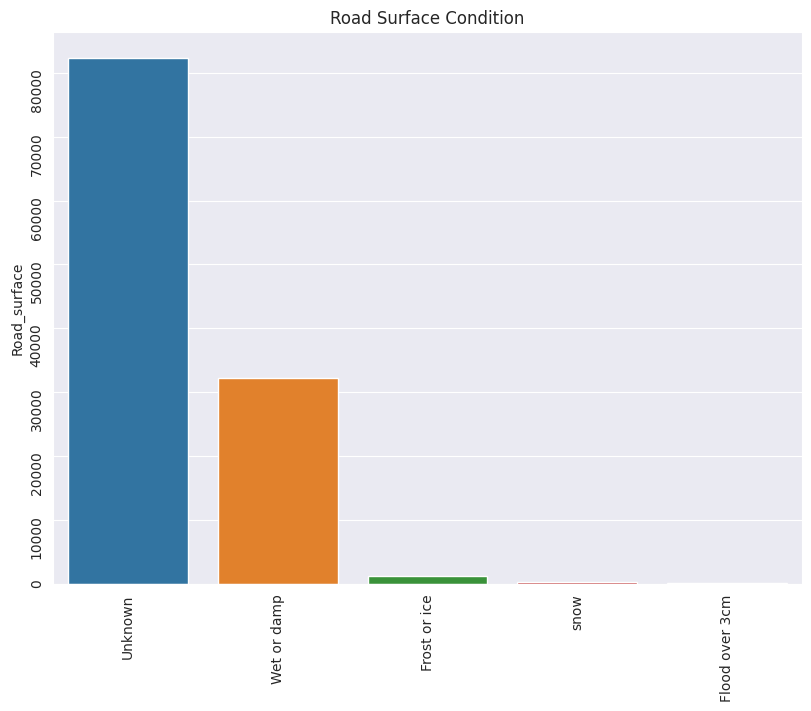

Unknown           82321
Wet or damp       32259
Frost or ice       1185
snow                245
Flood over 3cm      177
Name: Road_surface, dtype: int64

In [281]:
accidents_df['Road_surface'] = accidents_df['Road_Surface_Conditions'].map({1: 'Dry', 2: 'Wet or damp', 3: 'snow', 4: 'Frost or ice', 5: 'Flood over 3cm', 6: 'Oil and diesel', 7: 'Mud', 1: 'Unknown'})

fig, axs = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(8,7))
road_surface = accidents_df['Road_surface'].value_counts()
sns.barplot(ax=axs, x = road_surface.index, y = road_surface)
axs.set_title("Road Surface Condition")
axs.tick_params(labelrotation = 90)
plt.show()
road_surface

## 6. How does driver related variables affect the outcome (e.g., age of the driver, and the purpose of the journey)?


###### Age Band of the Driver

In [276]:
#Unique age band of drivers involved in accident
vehicles_df['Age_Band_of_Driver'].unique()

array([ 9, -1,  5,  7,  6,  8,  4, 11,  3, 10,  2,  1])

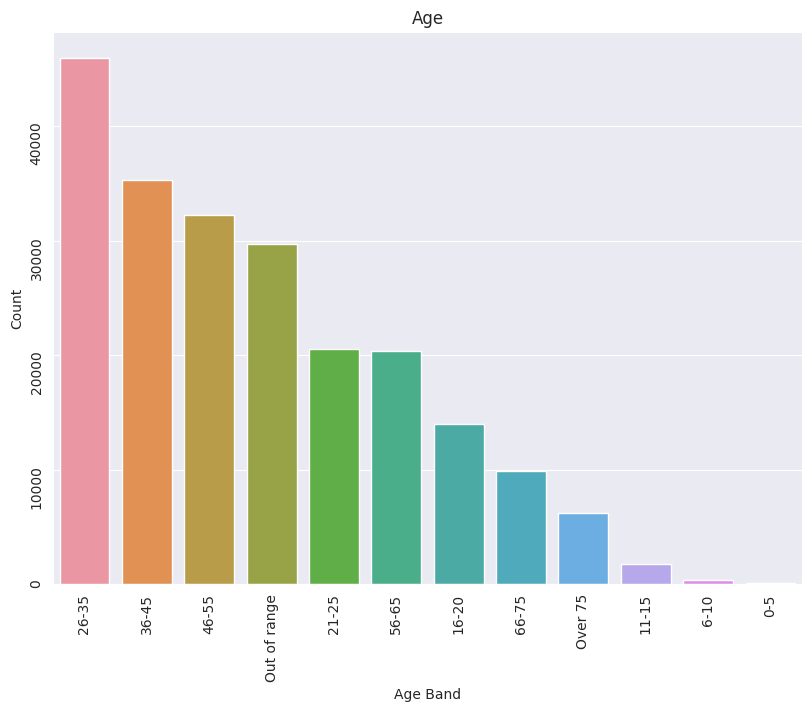

26-35           45993
36-45           35341
46-55           32281
Out of range    29756
21-25           20568
56-65           20344
16-20           13947
66-75            9848
Over 75          6169
11-15            1727
6-10              364
0-5                43
Name: Age_band, dtype: int64

In [277]:
# an histogram ranking the frequency of accidents according to the age band of the driver
fig, axs = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(8,7))
vehicles_df['Age_band'] = vehicles_df['Age_Band_of_Driver'].map({1: '0-5', 2: '6-10', 3: '11-15', 4: '16-20', 5: '21-25', 6: '26-35', 7: '36-45', 8: '46-55', 9: '56-65', 10: '66-75', 11: 'Over 75', -1: 'Out of range'}) 
age = vehicles_df['Age_band'].value_counts()
sns.barplot(ax=axs, x = age.index, y = age)
axs.set_title("Age")
axs.tick_params(labelrotation=90)
plt.ylabel('Count')
plt.xlabel('Age Band')
plt.show()
age

###### Journey Purpose

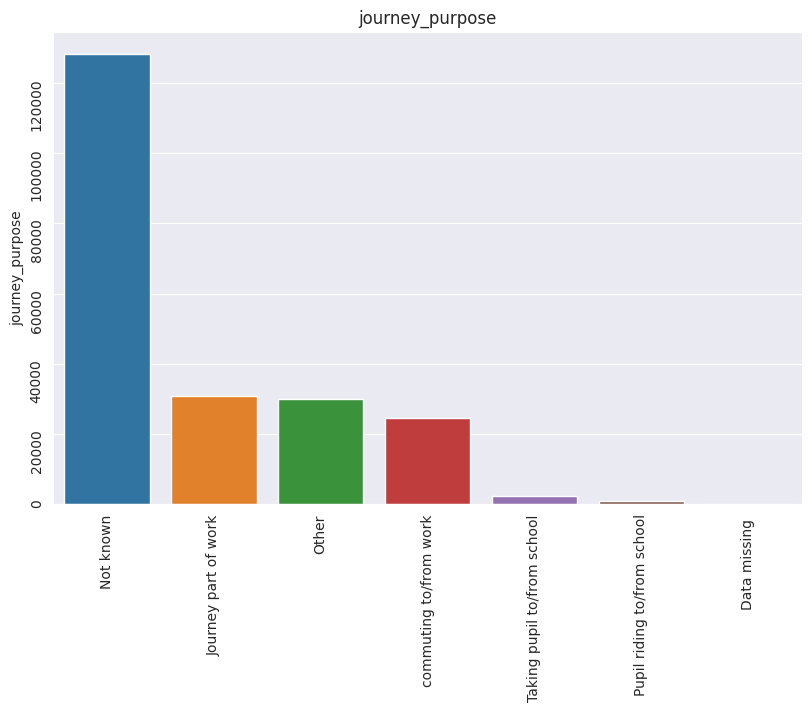

Not known                      128259
Journey part of work            30692
Other                           29807
commuting to/from work          24390
Taking pupil to/from school      2356
Pupil riding to/from school       819
Data missing                       58
Name: journey_purpose, dtype: int64

In [278]:
vehicles_df['journey_purpose'] = vehicles_df['Journey_Purpose_of_Driver'].map({1: 'Journey part of work', 2: 'commuting to/from work', 3: 'Taking pupil to/from school', 4: 'Pupil riding to/from school', 5: 'Other', 6:'Not known', 15:'Other/Not known', -1: 'Data missing '})
fig, axs = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(8,7))
journey_purpose = vehicles_df['journey_purpose'].value_counts()
sns.barplot(ax=axs, x = journey_purpose.index, y = journey_purpose)
axs.set_title("journey_purpose")
axs.tick_params(labelrotation=90)
plt.show()
journey_purpose

In [279]:
factors = ['Journey_Purpose_of_Driver','Age_of_Driver','Sex_of_Driver','Driver_Home_Area_Type','Age_of_Vehicle']
accidents_vehicles_df=accidents_df.merge(vehicles_df, on=['Accident_Index'], how='inner')
factors_coded= accidents_vehicles_df.dropna()
factors_coded.reset_index(drop=True)

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Vehicle_IMD_Decile,Age_band,journey_purpose
0,2019010128300,528218.0,180407.0,-0.153842,51.508057,1,3,2,3,2019-02-18,...,58,9,-1,-1,-1,2,1,2,56-65,Not known
1,2019010128300,528218.0,180407.0,-0.153842,51.508057,1,3,2,3,2019-02-18,...,-1,-1,-1,-1,-1,2,1,2,Out of range,Not known
2,2019010152270,530219.0,172463.0,-0.127949,51.436208,1,3,2,1,2019-01-15,...,24,5,-1,-1,-1,3,1,3,21-25,Not known
3,2019010152270,530219.0,172463.0,-0.127949,51.436208,1,3,2,1,2019-01-15,...,-1,-1,-1,-1,-1,6,1,6,Out of range,Not known
4,2019010155191,530222.0,182543.0,-0.124193,51.526795,1,3,2,1,2019-01-01,...,45,7,-1,-1,-1,4,1,4,36-45,Not known
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204033,201963DF03019,309990.0,271620.0,-3.322442,52.335266,63,1,3,2,2019-08-25,...,28,6,1582,2,7,6,1,6,26-35,Not known
204034,201963DF03319,297250.0,290970.0,-3.515306,52.506924,63,1,1,1,2019-09-22,...,35,6,-1,-1,-1,6,3,6,26-35,Not known
204035,201963DF03419,286940.0,245670.0,-3.651922,52.097790,63,1,1,2,2019-05-10,...,31,6,2198,1,17,5,2,5,26-35,Not known
204036,201963DF03619,293850.0,225950.0,-3.544971,51.921926,63,1,2,1,2019-03-11,...,52,8,599,1,8,3,1,3,46-55,Not known


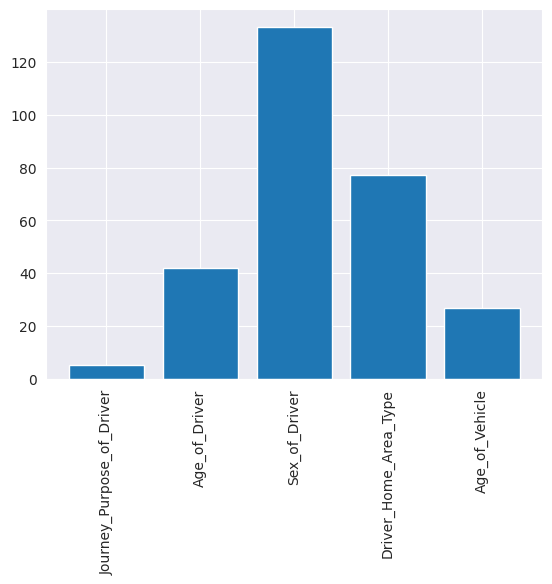

In [280]:
#Feature that influences road safety accident the most 
select_feature = factors_coded.filter( ['Age_of_Driver','Journey_Purpose_of_Driver','Accident_Severity','Sex_of_Driver','Age_of_Vehicle','Driver_Home_Area_Type'], axis=1)
conditional_feature = select_feature[(select_feature['Age_of_Driver'] > 0) & (select_feature['Journey_Purpose_of_Driver'] > 0) & (select_feature['Sex_of_Driver'] > 0) & (select_feature['Age_of_Vehicle'] > 0)& (select_feature['Driver_Home_Area_Type'] > 0)]
# Perform the feature selection
selector = SelectKBest(f_classif, k="all")
selector.fit(conditional_feature[factors], conditional_feature["Accident_Severity"])
scores = -np.log10(selector.pvalues_)
# plot the score using pyplot 
plt.bar(range(len(factors)), scores)
plt.xticks(range(len(factors)), factors, rotation='vertical')
plt.show()
# Sex of the driver has the greatest influence on road traffic accident

## => Summary

####